In [1]:
import numpy as np

import torch
import torch.nn as nn
import torch.utils.data as data_utils
import torchvision
import torchvision.transforms as transforms

import matplotlib.pyplot as plt

#from accelerate import Accelerator

In [2]:
from permutedMNIST import PermutedMNIST

In [3]:
class Net(nn.Module):
    def __init__(self, input_dims, code_dims):
        super(Net, self).__init__()
        self.input_dims = input_dims
        self.code_dims = code_dims
        
        self.encoder = nn.Sequential(
            nn.Linear(input_dims, code_dims),
            nn.ReLU()
        )
        self.decoder = nn.Sequential(
            nn.Linear(code_dims, input_dims),
            nn.Sigmoid()
        )
        
    def forward(self, x):
        x = x.view(-1, self.input_dims)
        encoded_x = self.encoder(x)
        reconstructed_x = self.decoder(encoded_x)
        return reconstructed_x

In [20]:
class Autoencoder():
    def __init__(self, input_dims, code_dims, lr=0.001):
        super(Autoencoder, self).__init__()
        self.device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
        self.net = Net(input_dims, code_dims).to(self.device)
        self.optimizer = torch.optim.Adam(self.net.parameters(), lr)
        
        #self.criterion = torch.nn.BCELoss()
        self.criterion = torch.nn.MSELoss()
        self.unreduced_criterion = torch.nn.MSELoss(reduction = 'none')
        
        self.input_dims = input_dims
        self.size = 0
        self.mean = 0
        self.var = 0
        self.std = 0
        
    def optimize_params(self, x, label):
        x = x.to(self.device).reshape(-1, self.input_dims)
        label = label.to(self.device).reshape(-1, self.input_dims)
        y = self._forward(x)
        
        self._update_params(y, label)
        self.update_statistics(y, label)

    def _forward(self, x):
        return self.net(x)

    def _backward(self, y, label):
        self.loss = self.criterion(y, label)
        self.loss.backward()
        #self.accelerator.backward(self.loss)

    def _update_params(self, y, label):
        self.optimizer.zero_grad()
        self._backward(y, label)
        self.optimizer.step()
        #self.scheduler.step()  # scheduler step in each iteration
        
    def update_statistics(self, y, label):
        #https://math.stackexchange.com/questions/3604607/can-i-work-out-the-variance-in-batches
        with torch.no_grad():
            #calculate batchwise loss
            new_element_loss = self.unreduced_criterion(y, label)
            new_loss = torch.mean(new_element_loss, axis=1)
            
            #calculate mean, var and batch size
            new_mean = torch.mean(new_loss).item()
            new_var = torch.var(new_loss).item()
            new_size = y.shape[0]
            #print(new_mean, new_var, new_size)
            
            #updating variance
            part1 = ((self.size - 1)*self.var + (new_size - 1)*new_var)/(self.size + new_size - 1)
            part2 = ((self.size*new_size)*np.square((self.mean - new_mean)))/((self.size + new_size)*(self.size+new_size - 1))
            self.var = part1 + part2
            
            #updating std
            self.std = np.sqrt(self.var)
            #print(self.std)
            
            #updating mean
            new_sum = torch.sum(new_loss).item()
            self.mean = (self.size*self.mean + new_sum)/(self.size + new_size)
            
            #updating size
            self.size += new_size
            
    def get_reduced_loss(self, y, label):
        with torch.no_grad():
            y = y.to(self.device).reshape(-1, self.input_dims)
            label = label.to(self.device).reshape(-1, self.input_dims)
            return self.criterion(y, label).item()
    
    def get_unreduced_loss(self, y, label):
        with torch.no_grad():
            y = y.to(self.device).reshape(-1, self.input_dims)
            label = label.to(self.device).reshape(-1, self.input_dims)
            return self.unreduced_criterion(y, label)
    
    def get_prediction(self, x):
        with torch.no_grad():
            return self._forward(x.to(self.device))

In [41]:
#MNIST_trainingdata = torchvision.datasets.MNIST('./MNIST/',train=True,download=True,transform=torchvision.transforms.ToTensor())
#MNIST_testdata = torchvision.datasets.MNIST('./MNIST/',train=False,download=True,transform=torchvision.transforms.ToTensor())

#setup dataloader
#MNIST_train_loader = torch.utils.data.DataLoader(MNIST_trainingdata,batch_size=64,shuffle=True)
#MNIST_test_loader = torch.utils.data.DataLoader(MNIST_testdata,batch_size=64,shuffle=False)

In [42]:
#CIFAR_transforms = transforms.Compose([transforms.Resize((28, 28)),transforms.Grayscale(),transforms.ToTensor()])

#CIFAR_trainingdata = torchvision.datasets.CIFAR10('./CIFAR/',train=True,download=True,transform=CIFAR_transforms)
#CIFAR_testdata = torchvision.datasets.CIFAR10('./CIFAR/',train=False,download=True,transform=CIFAR_transforms)

#setup dataloader
#CIFAR_train_loader = torch.utils.data.DataLoader(CIFAR_trainingdata,batch_size=64,shuffle=True)
#CIFAR_test_loader = torch.utils.data.DataLoader(CIFAR_testdata,batch_size=64,shuffle=False)

In [22]:
def train_autoencoder(train_loader, test_loader, model):
    train_losses = []
    test_losses = []

    for epoch in range(5): # We'll train for 5 "epochs"
        train_loss = 0
        test_loss = 0

        # Evaluation process
        for i, data in enumerate(test_loader):
            images, _, _ = data # Unpack the data into the images and labels
            predicted_output = model.get_prediction(images) # Apply our network to the images
            test_loss += model.get_reduced_loss(predicted_output, images) # Add the fit to the loss for tracking purposes

        # Training process
        for i, data in enumerate(train_loader):
            images, _, _ = data # Unpack the data into the images and labels
            model.optimize_params(images, images)
            train_loss += model.loss.item()
            
        # Add the current losses to our tracking lists
        train_losses += [train_loss/len(train_loader)]
        test_losses += [test_loss/len(test_loader)]

        # Print the current loss
        print(f'Epoch {epoch}, Train loss {train_loss}, Test loss {test_loss}')
        
    return model

In [6]:
#MNIST_model = Autoencoder(input_dims=28*28, code_dims=500)
#CIFAR_model = Autoencoder(input_dims=28*28, code_dims=500)

In [7]:
#MNIST_model = train_autoencoder(MNIST_train_loader, MNIST_test_loader, MNIST_model)
#CIFAR_model = train_autoencoder(CIFAR_train_loader, CIFAR_test_loader, CIFAR_model)

In [8]:
def visulize_test_autoencoder(test_loader, models):
    images, _ = next(iter(test_loader))
    image = images[np.random.randint(0, len(images))]

    show_image = image.cpu().detach().numpy().reshape((28,28))
    plt.imshow(show_image) # Plot the 28x28 image
    plt.show()
    
    for _, model in models.items():
        model_output = model.get_prediction(image)
        show_output = model_output[0].cpu().detach().numpy().reshape((28,28))
        #plt.imshow(show_output) # Plot the 28x28 image
        #plt.show()
        
        print("MNIST loss:", model.get_reduced_loss(model_output, image))

In [9]:
#visulize_test_autoencoder(MNIST_test_loader, [MNIST_model, CIFAR_model])

In [10]:
#visulize_test_autoencoder(CIFAR_test_loader, [MNIST_model, CIFAR_model])

In [11]:
def get_permute_mnist(num_task, batch_size, random_seed):
    train_loader = {}
    test_loader = {}
    np.random.seed(random_seed)
    idx = list(range(28 * 28))
    for i in range(num_task):
        train_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=True, permute_idx=idx, task_num = i),
                                                      batch_size=batch_size,
                                                      num_workers=4)
        test_loader[i] = torch.utils.data.DataLoader(PermutedMNIST(train=False, permute_idx=idx, task_num = i),
                                                     batch_size=batch_size)
        np.random.shuffle(idx)
    return train_loader, test_loader

In [12]:
NUM_TASK=20
BATCH_SIZE=600
RANDOM_SEED=42

In [13]:
permute_train_loaders, permute_test_loaders = get_permute_mnist(NUM_TASK, BATCH_SIZE, RANDOM_SEED)

C:\Program Files\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:75: UserWarning: train_data has been renamed data
  warnings.warn("train_data has been renamed data")
C:\Program Files\anaconda3\lib\site-packages\torchvision\datasets\mnist.py:80: UserWarning: test_data has been renamed data
  warnings.warn("test_data has been renamed data")


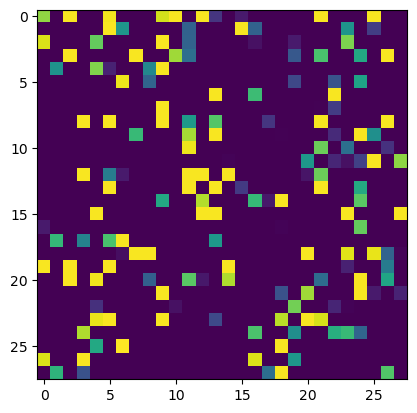

In [14]:
images, labels, index = next(iter(permute_train_loaders[1]))
image = images[0].cpu().detach().numpy().reshape((28,28))
plt.imshow(image) # Plot the 28x28 image
plt.show()

In [23]:
autoencoders = {}

for i in range(NUM_TASK):
    if(i>2):
        break
    autoencoders[i] = train_autoencoder(permute_train_loaders[i], permute_test_loaders[i], Autoencoder(input_dims=28*28, code_dims=250))


Epoch 0, Train loss 6.924171455204487, Test loss 3.943579003214836
Epoch 1, Train loss 3.239029537886381, Test loss 0.6835575178265572
Epoch 2, Train loss 2.207655917853117, Test loss 0.43445930629968643
Epoch 3, Train loss 1.6396753462031484, Test loss 0.3139985781162977
Epoch 4, Train loss 1.2672805869951844, Test loss 0.2438466539606452
Epoch 0, Train loss 6.858460795134306, Test loss 3.93233759701252
Epoch 1, Train loss 3.2275188229978085, Test loss 0.6714719831943512
Epoch 2, Train loss 2.2341847997158766, Test loss 0.4369999635964632
Epoch 3, Train loss 1.6688537104055285, Test loss 0.31980495899915695
Epoch 4, Train loss 1.2938870340585709, Test loss 0.2472309973090887
Epoch 0, Train loss 6.86918618157506, Test loss 3.9433748722076416
Epoch 1, Train loss 3.2440181393176317, Test loss 0.6766751557588577
Epoch 2, Train loss 2.1801779698580503, Test loss 0.43380219116806984
Epoch 3, Train loss 1.5980450212955475, Test loss 0.30859414488077164
Epoch 4, Train loss 1.2448749160394073,

In [73]:
#losses = [0]*NUM_TASK
#for i in range(NUM_TASK):
#    visulize_test_autoencoder(permute_test_loaders[i], autoencoders)

In [74]:
#for _, model in autoencoders.items():
#    print(model.mean - 3 * model.std, model.mean + 3 * model.std)

In [76]:
model = autoencoders[0]
print(model.mean - 3 * model.std, model.mean + 3 * model.std)
images, labels, _ = next(iter(permute_train_loaders[0]))
model_outputs = model.get_prediction(images)
unreduced_loss = model.get_unreduced_loss(model_outputs, images)

tensor([-0.0343], device='cuda:0') tensor([0.0491], device='cuda:0')


In [77]:
element_mean = torch.mean(unreduced_loss, axis=1)
element_mean
mean = torch.mean(element_mean)
mean
x = [item>model.mean - 3 * model.std and item<model.mean + 3 * model.std for item in element_mean]
sumX = sum(x)
sumX.item()

60

In [79]:
index=1

losses = [0]*len(autoencoders)
passes=0
errors=0
for _, data in enumerate(permute_train_loaders[index]):
    images, labels, _ = data
    for i in range(len(autoencoders)):
        model = autoencoders[i]
        model_outputs = model.get_prediction(images)
        losses[i] = model.get_reduced_loss(model_outputs, images)
    if(np.argmin(losses)==index):
        passes+=1
    else:
        errors+=1
        print(losses)
print(f"{errors}, {passes}")

0, 1000


In [112]:
def find_relatedness(reconstruction_error_autoencoder, reconstruction_error_data):
    with torch.no_grad():
        return torch.abs((reconstruction_error_autoencoder - reconstruction_error_data)/reconstruction_error_autoencoder)

In [9]:
def find_best_autoencoders(batchwise_data, autoencoders):
    with torch.no_grad():
        minimum_relatedness = float("inf")
        best_index=-1
        for index, autoencoder in autoencoders.items():
            prediction = autoencoder.get_prediction(batchwise_data)
            reconstruction_error_data = autoencoder.get_reduced_loss(prediction, batchwise_data)
            reconstruction_error_autoencoder = autoencoder.mean
            relatedness = find_relatedness(reconstruction_error_autoencoder, reconstruction_error_data)
            if relatedness.item()<minimum_relatedness:
                minimum_relatedness=relatedness
                best_index = index
        return best_index


In [10]:
import random

def get_conbined_permute_mnist(num_task, batch_size, random_seed):
    datasets = {}
    np.random.seed(random_seed)
    idx = list(range(28 * 28))
    for i in range(num_task):
        datasets[i] = PermutedMNIST(train=True, permute_idx=idx, task_num=i)
        np.random.shuffle(idx)
    dataset = torch.utils.data.ConcatDataset([x for _,x in datasets.items()])
    dataloader = torch.utils.data.DataLoader(dataset,
                                                  batch_size=batch_size,
                                                  shuffle = False,
                                                  num_workers = 4)
    
    return random.sample(list(dataloader), len(dataloader))

In [20]:
def find_num_of_outliers(batchwise_data, model):
    with torch.no_grad():
        model_outputs = model.get_prediction(batchwise_data)
        unreduced_loss = model.get_unreduced_loss(model_outputs, batchwise_data)
        element_mean = torch.mean(unreduced_loss, axis=1)
        outliers = batchwise_data.shape[0] - sum([item>model.mean - 3 * model.std and item<model.mean + 3 * model.std for item in element_mean]).item()
        return outliers


In [ ]:
auto_list = {}
expert_list = {}

outlier_threshold = 0.3*BATCH_SIZE

for _, data in enumerate(permute_train_loaders[0]):
    images, labels, index = data
    
    if len(auto_list)==0:
        best_autoencoder = Autoencoder(input_dims=28*28, code_dims=300)
        for epoch in range(500):
            best_autoencoder.optimize_params(images, images)
        auto_list[len(auto_list)] = best_autoencoder
        #to-do add initial expert
        continue
        
    best_index = find_best_autoencoders(images, auto_list)
    best_autoencoder = auto_list[best_index]
    
    outliers = find_num_of_outliers(images, best_autoencoder)
    
    if outliers > outlier_threshold:
        best_autoencoder = Autoencoder(input_dims=28*28, code_dims=300)
        for epoch in range(5):
            best_autoencoder.optimize_params(images, images)
        auto_list[len(auto_list)] = best_autoencoder
        #to-do add new expert
    else:
        best_autoencoder.optimize_params(images, images)
        #to-do train exsisting expert
        
    sampleImage, _, _ = next(iter(permute_train_loaders[2]))
    sampleOutliers = find_num_of_outliers(sampleImage, best_autoencoder)
    print(outliers, sampleOutliers)


In [87]:
BATCH_SIZE = 60

In [95]:
train_loader = get_conbined_permute_mnist(NUM_TASK, BATCH_SIZE, RANDOM_SEED)

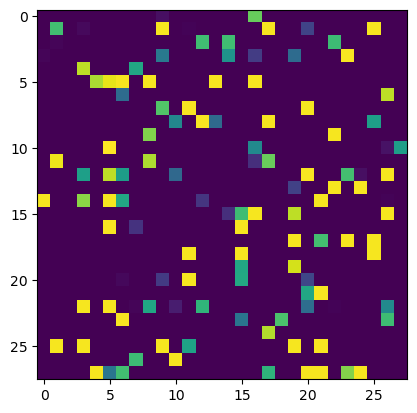

In [113]:
images, labels, _ = next(iter(train_loader))
image = images[0].cpu().detach().numpy().reshape((28,28))
plt.imshow(image) # Plot the 28x28 image
plt.show()

In [108]:
#5 tasks - 400 training epoches
NEW_AUTOENCODER_EPOCH = 700
TRAIN_AUTOENCODER_EPOCH = 10
CODE_DIM = 200

In [114]:
auto_list = {}
expert_list = {}

outlier_threshold = 0.003*BATCH_SIZE

#debug
record = {}

for i, data in enumerate(train_loader):
    images, labels, indicies = data
    
    #initial 
    if len(auto_list)==0:
        #debug
        print(f"[new @ batch {i}] autoencoder at {len(auto_list)} for index: {indicies[0].item()}")
        record[indicies[0].item()] = len(auto_list)
        
        #initial autoencoder
        new_autoencoder = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
        for epoch in range(NEW_AUTOENCODER_EPOCH):
            new_autoencoder.optimize_params(images, images)
        auto_list[len(auto_list)] = new_autoencoder
        
        #to-do add initial expert
        
        continue
    
    #find best autoencoder
    best_index = find_best_autoencoders(images, auto_list)
    best_autoencoder = auto_list[best_index]
    
    #calculate outliers
    outliers = find_num_of_outliers(images, best_autoencoder)
    #print(f"outliers for best autoencoders {best_index}: {outliers}")
    
    if outliers > outlier_threshold:
        #debug
        print(f"[new @ batch {i}] autoencoder at {len(auto_list)} for index: {indicies[0].item()}")
        if indicies[0].item() in record:
            print("error")
        else:
            record[indicies[0].item()] = len(auto_list)
        
        #add new autoencoder
        best_autoencoder = Autoencoder(input_dims=28*28, code_dims=CODE_DIM)
        for epoch in range(NEW_AUTOENCODER_EPOCH):
            best_autoencoder.optimize_params(images, images)
        auto_list[len(auto_list)] = best_autoencoder
        
        #to-do add new expert
        
    else:
        #debug
        #print(f"training autoencoder at {best_index} with index: {indicies[0].item()}")
        if not indicies[0].item() in record or record[indicies[0].item()] != best_index:
            print(f"[error @ batch {i}] training autoencoder at {best_index} with index: {indicies[0].item()}")
        
        #train best autoencoder
        for epoch in range(TRAIN_AUTOENCODER_EPOCH):
            best_autoencoder.optimize_params(images, images)
        
        #to-do train exsisting expert
    

    

[new @ batch 0] autoencoder at 0 for index: 3
[new @ batch 1] autoencoder at 1 for index: 15
[new @ batch 2] autoencoder at 2 for index: 18
[new @ batch 3] autoencoder at 3 for index: 17
[new @ batch 4] autoencoder at 4 for index: 2
[new @ batch 5] autoencoder at 5 for index: 13
[new @ batch 6] autoencoder at 6 for index: 5
[new @ batch 8] autoencoder at 7 for index: 11
[new @ batch 10] autoencoder at 8 for index: 16
[new @ batch 11] autoencoder at 9 for index: 12
[new @ batch 14] autoencoder at 10 for index: 0
[new @ batch 15] autoencoder at 11 for index: 14
[new @ batch 19] autoencoder at 12 for index: 19
[new @ batch 22] autoencoder at 13 for index: 9
[new @ batch 34] autoencoder at 14 for index: 10
[new @ batch 40] autoencoder at 15 for index: 4
[new @ batch 42] autoencoder at 16 for index: 6
[new @ batch 44] autoencoder at 17 for index: 7
[new @ batch 45] autoencoder at 18 for index: 8
[new @ batch 84] autoencoder at 19 for index: 1
